## <center> 数据挖掘第四次课程作业 <center>
####     <p style="text-align:right"> 吴嘉豪   _3220190894_ </p>
## 数据异常点检测 
### 1. python库引入

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

from pyod.models.pca import PCA
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.iforest import IForest

from time import *
import sys
import os

from sklearn.metrics import roc_auc_score
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from pyod.utils.utility import precision_n_scores

import warnings
warnings.filterwarnings('ignore')

## 2. 处理数据集 

__1. 数据集分析 - skin_benchmarks:__   
该数据集中包含多条skin_point的数据记录，数据中给出了skin_point所对应的RGB数值，并且由GT于origin.label提供了每一条记录点是否为异常点的记录，可以由此作为test集合上进行验证的label。

In [2]:
benchmark_dir1 = "F:\\course\\web\\homework4\\homework4\\skin\\benchmarks\\"
benchmark_dir = []
for files in os.listdir(benchmark_dir1):
    file_path = os.path.join(benchmark_dir1, files)
    benchmark_dir.append(file_path)
np.random.shuffle(benchmark_dir)
train_rate = 0.7
total = len(benchmark_dir)
print("Benchmark number : " , total)
print("Example : ", benchmark_dir[0])
data = pd.read_csv(benchmark_dir[0])
print("Benchmark size:", data.shape)
data.head()

Benchmark number :  1500
Example :  F:\course\web\homework4\homework4\skin\benchmarks\skin_benchmark_1389.csv
Benchmark size: (6000, 10)


,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B,noise..1
0,skin_point_178045,skin,binary,2,0.339599,nominal,-0.193805,-0.759199,-0.581255,-0.141928
1,skin_point_025102,skin,binary,1,0.652692,anomaly,-0.900568,-0.325441,0.590154,-2.127207
2,skin_point_232031,skin,binary,2,0.029378,nominal,-1.093322,-1.259690,-1.077382,0.425295
3,skin_point_007340,skin,binary,1,0.475041,anomaly,-0.017114,-0.025147,0.893342,-0.859298
4,skin_point_172955,skin,binary,2,0.340584,nominal,-0.225930,-0.942713,-1.587289,-1.726814


由上面的数据读取可以看出，在实验中使用了该数据总计包括1500个benchmark，每个benchmark中理论上包括6000条记录，在这里我们提取器中的R\G\B三种属性作为属性值，同时提取(nominal/anomaly)作为Ground Truth，进行数据点异常的判断。选取的方法包括：KNN / LOF / PCA / IForest。 

In [3]:
# KNN
ROC_mean = []
rank_n_mean = []
time_c_total = []
begin_time = time()
roc = []
rank_n =[]
for i in range(total):
    data = pd.read_csv(benchmark_dir[i])
    seqset = data[["R","G","B"]]
    labelset = data["ground.truth"]
    seq = seqset.values
    label = np.where(labelset == "nominal" , 0 ,1)
    seq,label = shuffle(seq,label)
    X_train = seq[:int(train_rate*len(seq))]
    X_test = seq[int(train_rate*len(seq)):]
    Y_train = label[:int(train_rate*len(seq))]
    Y_test = label[int(train_rate*len(seq)):]
    if np.sum(Y_test) < 5:
        continue
    clf = KNN(n_neighbors = 5) 
    clf.fit(X_train) # 使用seq 训练检测器clf
    y_test_pred = clf.predict(X_test) 
    y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(y_test_scores)
    check_consistent_length(y, y_pred)
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if i % 200 == 0:
        print("Current Iter "+str(i) ,": " , roc_)
    
    roc.append(roc_)
    rank_n.append(prn_)
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(roc))
rank_n_mean.append(np.mean(rank_n))
time_c_total.append(run_time)

Current Iter 0 :  0.6933
Current Iter 200 :  0.8067
Current Iter 800 :  0.2607
Current Iter 1000 :  0.9609
Current Iter 1200 :  0.9477
Current Iter 1400 :  0.2094


In [4]:
# LOF
begin_time = time()
roc = []
rank_n =[]
for i in range(total):
    data = pd.read_csv(benchmark_dir[i])
    seqset = data[["R","G","B"]]
    labelset = data["ground.truth"]
    seq = seqset.values
    label = np.where(labelset == "nominal" , 0 ,1)
    seq,label = shuffle(seq,label)
    X_train = seq[:int(train_rate*len(seq))]
    X_test = seq[int(train_rate*len(seq)):]
    Y_train = label[:int(train_rate*len(seq))]
    Y_test = label[int(train_rate*len(seq)):]
    if np.sum(Y_test) < 5:
        continue
    clf = LOF() 
    clf.fit(X_train) # 使用seq 训练检测器clf
    y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(y_test_scores)
    check_consistent_length(y, y_pred)
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if i % 200 == 0:
        print("Current Iter "+str(i) ,": " , roc_)
    
    roc.append(roc_)
    rank_n.append(prn_)
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(roc))
rank_n_mean.append(np.mean(rank_n))
time_c_total.append(run_time)

Current Iter 0 :  0.5158
Current Iter 200 :  0.3968
Current Iter 800 :  0.6185
Current Iter 1000 :  0.4931
Current Iter 1200 :  0.6902
Current Iter 1400 :  0.5524


In [5]:
# PCA
begin_time = time()
roc = []
rank_n =[]
for i in range(total):
    data = pd.read_csv(benchmark_dir[i])
    seqset = data[["R","G","B"]]
    labelset = data["ground.truth"]
    seq = seqset.values
    label = np.where(labelset == "nominal" , 0 ,1)
    seq,label = shuffle(seq,label)
    X_train = seq[:int(train_rate*len(seq))]
    X_test = seq[int(train_rate*len(seq)):]
    Y_train = label[:int(train_rate*len(seq))]
    Y_test = label[int(train_rate*len(seq)):]
    if np.sum(Y_test) < 5:
        continue
    clf = PCA() 
    clf.fit(X_train) # 使用seq 训练检测器clf
    y_test_pred = clf.predict(X_test) 
    y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(y_test_scores)
    check_consistent_length(y, y_pred)
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if i % 200 == 0:
        print("Current Iter "+str(i) ,": " , roc_)
        
    roc.append(roc_)
    rank_n.append(prn_)
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(roc))
rank_n_mean.append(np.mean(rank_n))
time_c_total.append(run_time)

Current Iter 0 :  0.4384
Current Iter 200 :  0.5335
Current Iter 800 :  0.5453
Current Iter 1000 :  0.5671
Current Iter 1200 :  0.7248
Current Iter 1400 :  0.6665


In [6]:
# IForest
begin_time = time()
roc = []
rank_n =[]
for i in range(total):
    data = pd.read_csv(benchmark_dir[i])
    seqset = data[["R","G","B"]]
    labelset = data["ground.truth"]
    seq = seqset.values
    label = np.where(labelset == "nominal" , 0 ,1)
    seq,label = shuffle(seq,label)
    X_train = seq[:int(train_rate*len(seq))]
    X_test = seq[int(train_rate*len(seq)):]
    Y_train = label[:int(train_rate*len(seq))]
    Y_test = label[int(train_rate*len(seq)):]
    if np.sum(Y_test) < 5:
        continue
    clf = IForest(n_estimators = 50) 
    clf.fit(X_train) # 使用seq 训练检测器clf
    y_test_pred = clf.predict(X_test) 
    y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(y_test_scores)
    check_consistent_length(y, y_pred)
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if i % 200 == 0:
        print("Current Iter "+str(i) ,": " , roc_)
    
    roc.append(roc_)
    rank_n.append(prn_)
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(roc))
rank_n_mean.append(np.mean(rank_n))
time_c_total.append(run_time)

Current Iter 0 :  0.4276
Current Iter 200 :  0.7478
Current Iter 800 :  0.4635
Current Iter 1000 :  0.868
Current Iter 1200 :  0.89
Current Iter 1400 :  0.443


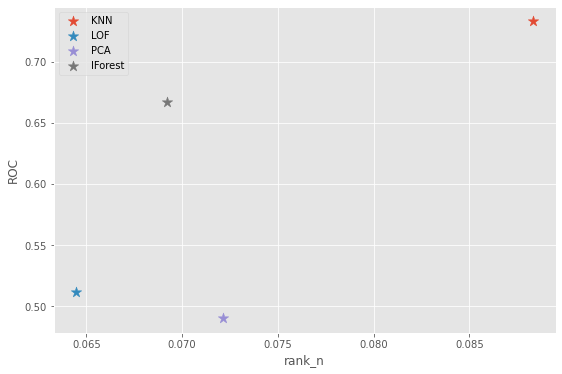

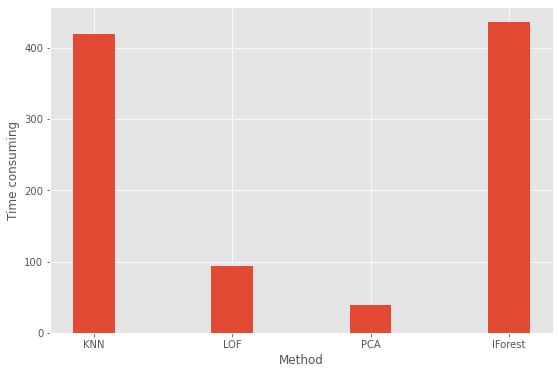

In [8]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
ROC = np.array(ROC_mean)
rank_n = np.array(rank_n_mean)
name = ["KNN" , "LOF" , "PCA","IForest"]
perfomance = np.array([ROC , rank_n])
for i in range(4):
    plt.scatter(rank_n[i] ,ROC[i] , s = 120 ,marker = "*")
plt.xlabel("rank_n")
plt.ylabel("ROC")
# plt.grid()
plt.legend(name)
plt.show()

plt.figure(figsize=(9,6))
plt.bar(name, time_c_total ,width=0.3)
plt.xlabel("Method")
plt.ylabel("Time consuming")
# plt.grid()
plt.show()

从上面尝试的及几种方法来看，总体来说KNN与IForest的表现结果最好，相应的其计算异常点的消耗时间也更长，而PCA的表现分类结果不好，这里我认为可能是因为Skin的属性仅仅是三维数据，因而PCA主要用于降维并不能有效地进行异常点监测的缘故。

__2. 数据集分析 - pageb_benchmarks:__   
该数据集中包含多条pageb_point的数据记录，数据中给出了pageb所对应的十维属性数值，并且由ground.truth属性提供了每一条记录点是否为异常点的记录。
由上面的数据读取可以看出，在实验中使用了该数据总计包括940个benchmark，每个benchmark中理论上包括4466条记录，在这里我们提取器中的多种属性作为属性值，同时提取(nominal/anomaly)作为Ground Truth，进行数据点异常的判断。选取的方法依旧为：KNN / LOF / PCA / IForest。

In [9]:
benchmark_dir1 = "F:\\course\\web\\homework4\\homework4\\pageb\\benchmarks\\"
benchmark_dir = []
for files in os.listdir(benchmark_dir1):
    file_path = os.path.join(benchmark_dir1, files)
    benchmark_dir.append(file_path)
np.random.shuffle(benchmark_dir)
train_rate = 0.7
total = len(benchmark_dir)
print("Benchmark number : " , total)
print("Example : ", benchmark_dir[0])
data = pd.read_csv(benchmark_dir[0])
print("Benchmark size:", data.shape)
data.head()

Benchmark number :  940
Example :  F:\course\web\homework4\homework4\pageb\benchmarks\pageb_benchmark_1000.csv
Benchmark size: (4466, 46)


,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,...,noise..21,noise..22,noise..23,noise..24,noise..25,noise..26,noise..27,noise..28,noise..29,noise..30
0,pageb_point_0015,pageb,multiclass,1,0.016498,nominal,-0.235923,-0.719726,-0.238465,-0.409949,...,-0.353623,-0.092047,-0.238877,2.819271,0.134462,-0.099250,-0.404420,-0.411545,0.777336,0.958750
1,pageb_point_5435,pageb,multiclass,2,0.008996,anomaly,-0.499628,-0.170571,-0.232691,1.831895,...,3.664795,-0.197531,-0.165466,-0.440790,0.462597,-0.155507,1.149597,-0.324194,-0.207533,0.118996
2,pageb_point_0485,pageb,multiclass,1,0.014624,nominal,-0.130441,-0.266456,-0.149794,-0.207759,...,-0.527958,-0.240040,-0.238877,0.160665,-2.877352,-0.138630,-0.625569,-0.154834,0.618965,-0.368380
3,pageb_point_0768,pageb,multiclass,2,0.001587,anomaly,-0.499628,-0.388490,-0.237846,1.017662,...,-0.301322,-0.201467,-0.169178,-0.676142,0.878626,-0.594309,0.575806,-0.036770,0.256857,-0.300349
4,pageb_point_0206,pageb,multiclass,4,0.710344,anomaly,-0.288664,-0.763310,-0.245064,-0.434930,...,-0.632559,-0.276251,0.150451,-0.554108,1.259497,-0.200512,-0.601661,-0.169295,1.058403,0.627632


In [16]:
# KNN
ROC_mean = []
rank_n_mean = []
time_c_total = []
begin_time = time()
roc = []
rank_n =[]
for i in range(total):
    data = pd.read_csv(benchmark_dir[i])
    seqset = data[["V","V.1","V.2","V.3","V.4","V.5","V.6","V.7","V.8","V.9"]]
    labelset = data["ground.truth"]
    seq = seqset.values
    label = np.where(labelset == "nominal" , 0 ,1)
    seq,label = shuffle(seq,label)
    X_train = seq[:int(train_rate*len(seq))]
    X_test = seq[int(train_rate*len(seq)):]
    Y_train = label[:int(train_rate*len(seq))]
    Y_test = label[int(train_rate*len(seq)):]
    if np.sum(Y_test) < 5:
        continue
    clf = KNN(n_neighbors = 5) 
    clf.fit(X_train) # 使用seq 训练检测器clf
    y_test_pred = clf.predict(X_test) 
    y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(y_test_scores)
    check_consistent_length(y, y_pred)
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if i % 200 == 0:
        print("Current Iter "+str(i) ,": " , roc_)
    
    roc.append(roc_)
    rank_n.append(prn_)
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(roc))
rank_n_mean.append(np.mean(rank_n))
time_c_total.append(run_time)

Current Iter 0 :  0.8494
Current Iter 200 :  0.8672
Current Iter 600 :  0.9061
Current Iter 800 :  0.8169


In [17]:
# LOF
begin_time = time()
roc = []
rank_n =[]
for i in range(total):
    data = pd.read_csv(benchmark_dir[i])
    seqset = data[["V","V.1","V.2","V.3","V.4","V.5","V.6","V.7","V.8","V.9"]]
    labelset = data["ground.truth"]
    seq = seqset.values
    label = np.where(labelset == "nominal" , 0 ,1)
    seq,label = shuffle(seq,label)
    X_train = seq[:int(train_rate*len(seq))]
    X_test = seq[int(train_rate*len(seq)):]
    Y_train = label[:int(train_rate*len(seq))]
    Y_test = label[int(train_rate*len(seq)):]
    if np.sum(Y_test) < 5:
        continue
    clf = LOF() 
    clf.fit(X_train) # 使用seq 训练检测器clf
    y_test_pred = clf.predict(X_test) 
    y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(y_test_scores)
    check_consistent_length(y, y_pred)
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if i % 200 == 0:
        print("Current Iter "+str(i) ,": " , roc_)
    
    roc.append(roc_)
    rank_n.append(prn_)
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(roc))
rank_n_mean.append(np.mean(rank_n))
time_c_total.append(run_time)

Current Iter 0 :  0.8876
Current Iter 200 :  0.8059
Current Iter 600 :  0.811
Current Iter 800 :  0.7123


In [18]:
# PCA
begin_time = time()
roc = []
rank_n =[]
for i in range(total):
    data = pd.read_csv(benchmark_dir[i])
    seqset = data[["V","V.1","V.2","V.3","V.4","V.5","V.6","V.7","V.8","V.9"]]
    labelset = data["ground.truth"]
    seq = seqset.values
    label = np.where(labelset == "nominal" , 0 ,1)
    seq,label = shuffle(seq,label)
    X_train = seq[:int(train_rate*len(seq))]
    X_test = seq[int(train_rate*len(seq)):]
    Y_train = label[:int(train_rate*len(seq))]
    Y_test = label[int(train_rate*len(seq)):]
    if np.sum(Y_test) < 5:
        continue
    clf = PCA() 
    clf.fit(X_train) # 使用seq 训练检测器clf
    y_test_pred = clf.predict(X_test) 
    y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(y_test_scores)
    check_consistent_length(y, y_pred)
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if i % 200 == 0:
        print("Current Iter "+str(i) ,": " , roc_)
    
    roc.append(roc_)
    rank_n.append(prn_)
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(roc))
rank_n_mean.append(np.mean(rank_n))
time_c_total.append(run_time)

Current Iter 0 :  0.9439
Current Iter 200 :  0.9223
Current Iter 600 :  0.9139
Current Iter 800 :  0.9064


In [19]:
# IForest
begin_time = time()
roc = []
rank_n =[]
for i in range(total):
    data = pd.read_csv(benchmark_dir[i])
    seqset = data[["V","V.1","V.2","V.3","V.4","V.5","V.6","V.7","V.8","V.9"]]
    labelset = data["ground.truth"]
    seq = seqset.values
    label = np.where(labelset == "nominal" , 0 ,1)
    seq,label = shuffle(seq,label)
    X_train = seq[:int(train_rate*len(seq))]
    X_test = seq[int(train_rate*len(seq)):]
    Y_train = label[:int(train_rate*len(seq))]
    Y_test = label[int(train_rate*len(seq)):]
    if np.sum(Y_test) < 5:
        continue
    clf = IForest(n_estimators = 100) 
    clf.fit(X_train) # 使用seq 训练检测器clf
    y_test_pred = clf.predict(X_test) 
    y_test_scores = clf.decision_function(X_test) 
    
    y = column_or_1d(Y_test)
    y_pred = column_or_1d(y_test_scores)
    check_consistent_length(y, y_pred)
    roc_ = np.round(roc_auc_score(y, y_pred), decimals=4)
    prn_ = np.round(precision_n_scores(y, y_pred), decimals=4)
    if i % 200 == 0:
        print("Current Iter "+str(i) ,": " , roc_)
    
    roc.append(roc_)
    rank_n.append(prn_)
end_time = time()
run_time = end_time-begin_time
ROC_mean.append(np.mean(roc))
rank_n_mean.append(np.mean(rank_n))
time_c_total.append(run_time)

Current Iter 0 :  0.8943
Current Iter 200 :  0.907
Current Iter 600 :  0.9025
Current Iter 800 :  0.8984


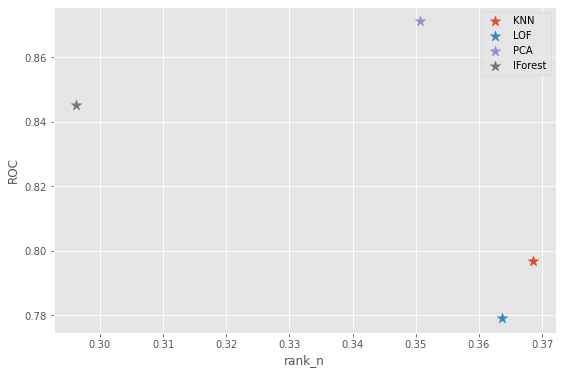

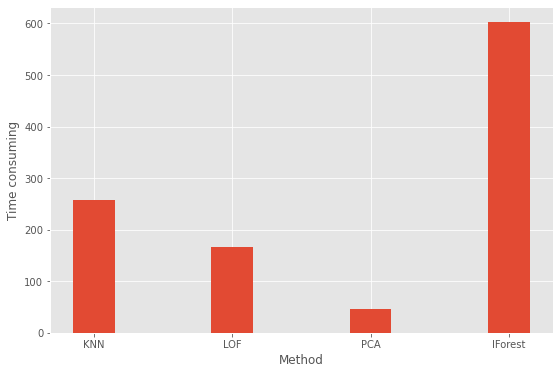

In [21]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
ROC = np.array(ROC_mean)
rank_n = np.array(rank_n_mean)
name = ["KNN" , "LOF" , "PCA","IForest"]
perfomance = np.array([ROC , rank_n])
for i in range(4):
    plt.scatter(rank_n[i] ,ROC[i] , s = 120 ,marker = "*")
plt.xlabel("rank_n")
plt.ylabel("ROC")
# plt.grid()
plt.legend(name)
plt.show()

plt.figure(figsize=(9,6))
plt.bar(name, time_c_total ,width=0.3)
plt.xlabel("Method")
plt.ylabel("Time consuming")
# plt.grid()
plt.show()

从这里我们可以看出，在面对像pageb这样的更高位属性的时候，像PCA这样的方法则表现出了更好的异常点检测性能，比KNN与LOF这样的检测算法表现更好，然而基于类似Ensemble的IForest方法同样表现出了较好的异常点检测能力，然而这也代表着训练多个分支的时间消耗更长(n_forest = 100的训练时长)。

__Github:__  https://github.com/FadedFate/Data_Homeworkw4